# Universal Differential Equations for chemical kinetics

Use the chemical models from [Estimating reaction model parameter uncertainty with Markov Chain Monte Carlo](http://dx.doi.org/10.1016/j.compchemeng.2012.07.011) for more background and a Julia implementation of that paper, see the notebook `Chemical_Kinetic_MCMC.ipynb` 

The goal here will be to apply the methodology to identify the model structure itself, not just the parameter estimates.  


In [1]:
# The goal of this script is to apply the SINDy 
# algorithm for model discovery (like in universal 
# differential equations) to Albrecht 2012 reaction systems
# doi: 10.1016/j.compchemeng.2012.07.011
cd(@__DIR__)
using Pkg; Pkg.activate("."); Pkg.instantiate()

using DiffEqBase
using OrdinaryDiffEq
using DifferentialEquations
#using StaticArrays
using DataDrivenDiffEq
using BenchmarkTools
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Interpolations
using Plots
using Random
using MAT
gr()

 Activating environment at `~/Dropbox/julia/universal_differential_equations/ChemicalKinetics/Project.toml`


Plots.GRBackend()

In [2]:
R = 8.314/1000 # kJ/mol-K
T_ref = 293.15
Temps = [283.15, 293.15, 303.15]

θ₁ = 0.1
θ₂ = [0.1]
θ₃ = [0.48,0.09,75.0,80.0]
logθ₃ = log.(θ₃)
θ₄ = [65.4,365.0,5.4,0.881]


C₀₁ = 0.1  # A₀ = B₀ = 100mM
C₀₂ = [100e-3,150e-3,0]
C₀₃ = [186e-3,353e-3,0.0,0.0]
C₀₄ = [220e-3 660e-3 264e-3 0 0 0 0;
        220e-3 110e-3 264e-3 0 0 0 0;
        220e-3 660e-3 132e-3 0 0 0 0]  # Three sets of initial concentrations
cat₀ =  2.2e-3

model1(inv_c,θ₁,t) = θ₁*t.+inv_c  # linear model for second order kinetics

function model2(dc,c,p,t)
    dc[1] = -p[1]*c[1]*c[2]
    dc[2] = -p[1]*c[1]*c[2]
    dc[3] = p[1]*c[1]*c[2]
end

arr_rate(k::Real,Ea::Real,T::Real) = k*exp(-Ea/R*((1.0/T)-(1.0/T_ref)))

function model3(dc,c,θ₃T,t)
    dc[1] = -arr_rate(θ₃T[1],θ₃T[3],θ₃T[5])*c[1]*c[2]
    dc[4] = arr_rate(θ₃T[2],θ₃T[4],θ₃T[5])*c[3]*c[2]
    dc[2] =  -arr_rate(θ₃T[1],θ₃T[3],θ₃T[5])*c[1]*c[2]-arr_rate(θ₃T[2],θ₃T[4],θ₃T[5])*c[3]*c[2]
    dc[3] = arr_rate(θ₃T[1],θ₃T[3],θ₃T[5])*c[1]*c[2]-arr_rate(θ₃T[2],θ₃T[4],θ₃T[5])*c[3]*c[2]
end

function model4(dc,c,θ₄,t)
    cat = max(1e-10,cat₀ - c[5] - c[6] - c[7])
    dc[1] = -θ₄[1]*c[1]*cat  #A
    dc[2] = -θ₄[2]*c[2]*c[5] # B
    dc[3] = -θ₄[3]*c[3]*c[6] #C
    dc[4] = θ₄[4]*c[7] #D
    dc[5] = dc[2] - dc[1] #Acat
    dc[6] = dc[3] - dc[2] #ABcat
    dc[7] = -dc[3] - dc[4] #Dcat
end
;

In [3]:
function model3set(θ₃::Array{<:Real,1},timepoints::Array{<:Real,1})
    Y  = []
    for ix in 1:length(Temps)
        prob3 = ODEProblem(model3, C₀₃, (0.0,maximum(timepoints)), [θ₃...,Temps[ix]])
        solution3 = solve(prob3, saveat = timepoints, verbose = false,save_idxs=[3,4],save_everystep=false)
        push!(Y,hcat(solution3.u...))
    end 
    return Y
end

function model4set(θ₄::Array{<:Real,1},timepoints::Array{<:Real,1})
    Y  =  []
    for ix in 1:size(C₀₄,1)
        prob4 = ODEProblem(model4, C₀₄[ix,:], (0.0,maximum(timepoints)), θ₄)
        solution4 = solve(prob4, saveat = timepoints, verbose = false,save_idxs=[1],save_everystep=false)
        push!(Y, vcat(solution4.u...))
    end 
    return Y
end
;

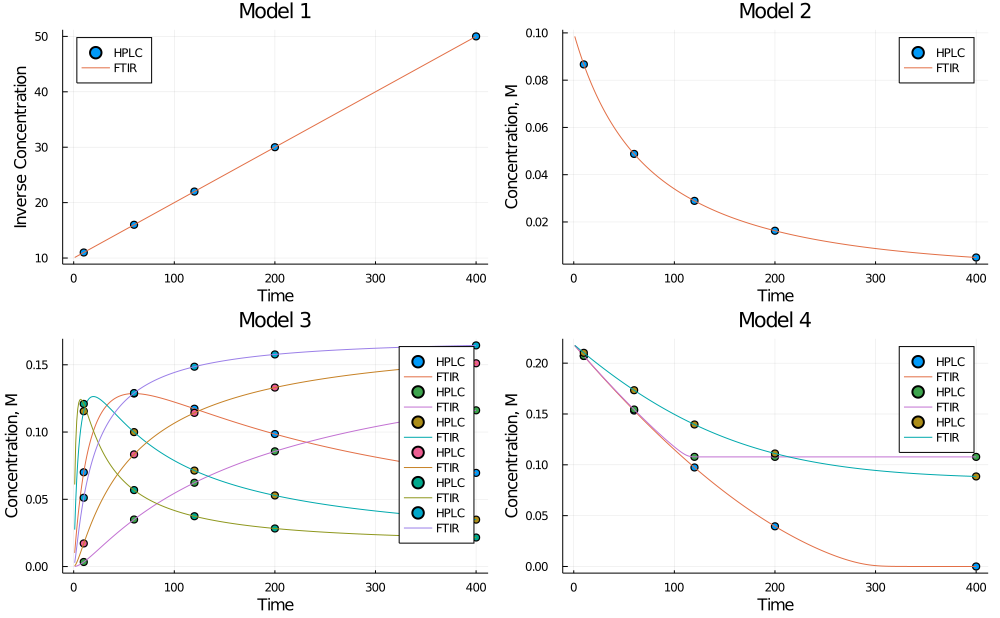

In [4]:
tspan_SD = Array{Float64,1}([10, 60, 120, 200, 400])
tspan_HD = Array{Float64,1}((1:400))

# Model 1
solution1_SD = model1(1 ./C₀₁,θ₁,tspan_SD)
solution1_HD = model1(1 ./C₀₁,θ₁,tspan_HD)
p1 = scatter(tspan_SD,solution1_SD,label="HPLC")
plot!(p1,tspan_HD,solution1_HD,label="FTIR",legend=:topleft)
xlabel!(p1,"Time")
ylabel!(p1,"Inverse Concentration")
title!("Model 1")

# Model 2
## generate some data
prob2_SD = ODEProblem(model2, C₀₂, (0.0,maximum(tspan_SD)), θ₂)
prob2_HD = ODEProblem(model2, C₀₂, (0.0,maximum(tspan_HD)), θ₂)

solution2_SD = solve(prob2_SD, saveat = tspan_SD, verbose = false,save_idxs= [1], save_everystep = false)
solution2_HD = solve(prob2_HD, saveat = tspan_HD, verbose = false,save_idxs = [1], save_everystep = false)

p2 = scatter(solution2_SD.t,vcat(solution2_SD.u...),label="HPLC")
plot!(p2,solution2_HD.t,vcat(solution2_HD.u...),label="FTIR")
ylabel!("Concentration, M")
xlabel!("Time")
title!("Model 2")

# Model 3
solution3_SD = model3set(θ₃,tspan_SD)
solution3_HD = model3set(θ₃,tspan_HD)

p3 = plot(title="Model 3")
for temp in 1:3
    for conc in 1:2
        scatter!(p3,tspan_SD,solution3_SD[temp][conc,:],label="HPLC")
        plot!(p3,tspan_HD,solution3_HD[temp][conc,:],label="FTIR")
    end
end
ylabel!("Concentration, M")
xlabel!("Time")
# Model 4
solution4_SD = model4set(θ₄,tspan_SD)
solution4_HD = model4set(θ₄,tspan_HD)
p4 = plot(title="Model 4")
for ICs in 1:3
        scatter!(p4,tspan_SD,solution4_SD[ICs],label="HPLC")
        plot!(p4,tspan_HD,solution4_HD[ICs],label="FTIR")
end
ylabel!("Concentration, M")

xlabel!("Time")

l = @layout [a b; c d]
plot(p1,p2,p3,p4, layout = l,size=(1000,618))

# Try approach from "Universal Differential Equations"

In [5]:
## Try using UDE approach on model2

# to start use all data points, later we will start adding wierd errors and missing data

# switch to full solution:
solution2_SD = solve(prob2_SD, saveat = tspan_SD, verbose = false,save_idxs = [1,2,3], save_everystep = false)
solution2_HD = solve(prob2_HD, saveat = tspan_HD, verbose = false,save_idxs = [1,2,3], save_everystep = false)

X = hcat(solution2_SD.u...)
ϵ= 0.08./2*maximum(X)
Random.seed!(42) # set seed
Xₙ = X + (ϵ)*randn(eltype(X), size(X))
;

In [6]:
### Neural ODE
# beware local minima!  see https://diffeqflux.sciml.ai/dev/examples/local_minima/

L_basic = FastChain(FastDense(2, 16, tanh),FastDense(16, 16, tanh), FastDense(16, 3))
p = initial_params(L_basic)

function dudt_nn(u, p,t)
    A,B,C = u
    d = L_basic([A,B],p)  # make the problem easy for now
    [d[1],
    d[2],
    d[3]]
end
prob_nn = ODEProblem(dudt_nn,C₀₂, (0.0,maximum(tspan_SD)), p)

function predict(θ)
    solution2 = solve(prob_nn, Vern7(),u0 = C₀₂, p=θ, saveat = tspan_SD,
                         abstol=1e-6, reltol=1e-6,save_idxs=[1,2,3],
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP()))
    hcat(solution2.u...)
end

# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, (Xₙ .- pred)), pred
end

losses = [] # remove `const`

callback(θ,l,pred) = begin
    push!(losses, l)
    false
end
;

loss: 0.362: 100%|██████████████████████████████████████| Time: 0:06:27


Final training loss for one network model after 406 iterations: 0.0005202565055077476


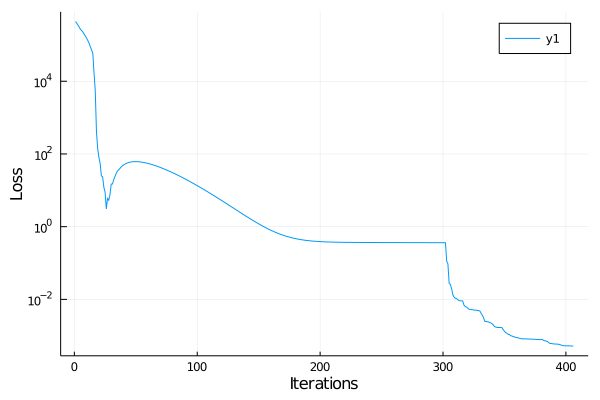

In [7]:
# First train with ADAM for better convergence
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.001), cb=callback, maxiters = 300,save_best=true)

# Train with BFGS
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 300)

println("Final training loss for one network model after $(length(losses)) iterations: $(losses[end])")

# Plot the losses
plot(losses, yaxis = :log, xlabel = "Iterations", ylabel = "Loss")

L2 of full solutions 0.9745001564660272


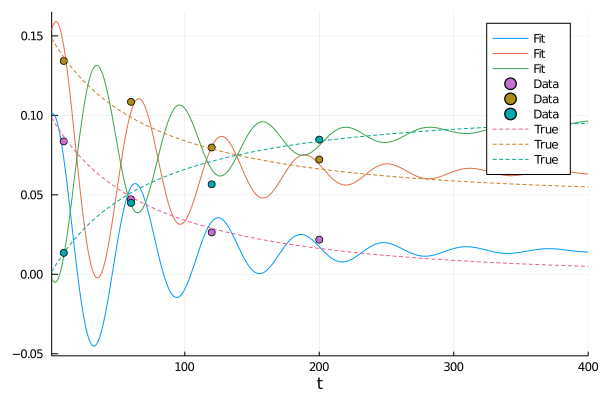

In [8]:
# Plot the data the truth, and the approximation
NNsolution = solve(prob_nn, saveat = tspan_HD, p=res2.minimizer,verbose = false,save_idxs = [1,2,3], save_everystep = false)
println("L2 of full solutions $(norm(NNsolution-solution2_HD,2))")
plot(NNsolution,labels="Fit")
scatter!(solution2_SD.t,Xₙ',label="Data")  
plot!(solution2_HD,line=:dash,label="True")  

The raw NN approximation fails miserably!  Accruately fitting the whole series is a tall order, even for ADAM.  Some work has utilized multiple starting timepoints to fit a short time horizon; that could be a good option but is not explored here with our sparse data set.  Instead,lets do some tweakin of the NN architecture:

loss: 0.000392: 100%|███████████████████████████████████| Time: 0:00:23


Final training loss for two network model after 362 iterations: 0.00030022612927604555


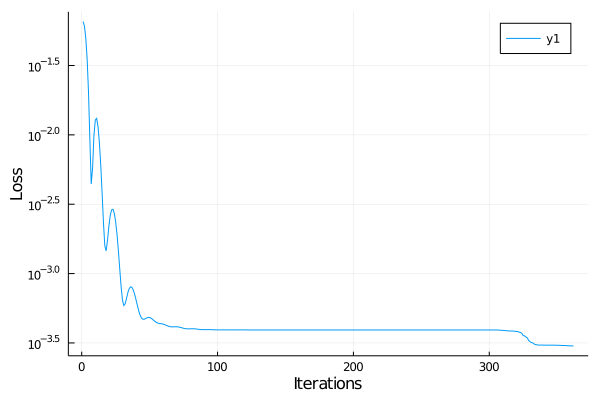

In [9]:
####
# Try a different approach, use two networks one for stoichiometry, another for rNNsolutiontes
#

nrxn = 1
ncomp = 3
Lstoi = FastChain(FastDense(1,ncomp*nrxn,tanh)) # teeny network
ps = initial_params(Lstoi)
Lrxn = FastChain(FastDense(ncomp,16,tanh), FastDense(16,16,tanh), FastDense(16,nrxn))
pr = initial_params(Lrxn)
L_dual(u,p) = reshape(Lstoi(0.0,p[1:(ncomp*nrxn*2)]),ncomp,nrxn)*Lrxn(u,p[(ncomp*nrxn*2+1):end])


function dudt_nn2(u, p,t)
    A,B,C = u
    d = L_dual(u,p)  # make the problem easy for now
    [d[1],
    d[2],
    d[3]]
end
p = [ps;pr]
prob_nn2 = ODEProblem(dudt_nn2,C₀₂, (0.0,maximum(tspan_SD)), p)

function predict(θ)
    solution2 = solve(prob_nn2, Vern7(),u0 = C₀₂, p=θ, saveat = tspan_SD,
                         abstol=1e-6, reltol=1e-6,save_idxs=[1,2,3],
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP()))
    hcat(solution2.u...)
end

# No regularisation right now, perhaps try multi starting?
function loss(θ)
    pred = predict(θ)
    sum(abs2, (Xₙ.- pred)), pred
end

losses = []

callback(θ,l,pred) = begin
    push!(losses, l)
    false
end

# First train with ADAM for better convergence
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.001), cb=callback, maxiters = 300,save_best=true)

# Train with BFGS
res22 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 300)



println("Final training loss for two network model after $(length(losses)) iterations: $(losses[end])")

# Plot the losses
plot(losses, yaxis = :log, xlabel = "Iterations", ylabel = "Loss")

L2 of full solutions 0.13465042430084218


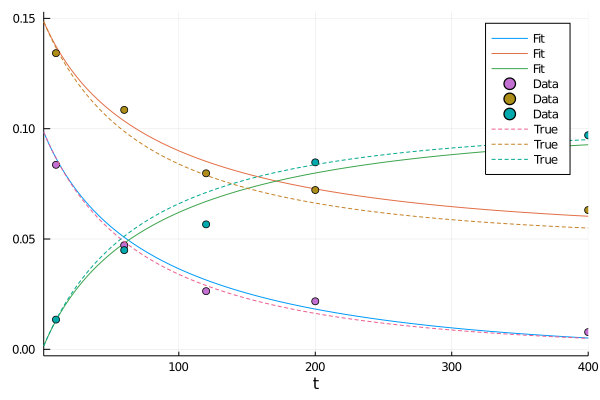

In [10]:
# Plot the data the truth, and the approximation
NNsolution = solve(prob_nn2, saveat = tspan_HD, p=res22.minimizer,verbose = false,save_idxs = [1,2,3], save_everystep = false)
println("L2 of full solutions $(norm(NNsolution-solution2_HD,2))")
plot(NNsolution,labels="Fit")
scatter!(solution2_SD.t,Xₙ',label="Data")  
plot!(solution2_HD,line=:dash,label="True")  

Ok, this is much better, but we havent hit the ideal solution, yet.  Try one more idea; using a basis set of expanded functions instead of just individual species in the fit:


loss: 0.00925: 100%|████████████████████████████████████| Time: 0:00:12


Final training loss for two network model after 388 iterations: 0.00032087438673339115


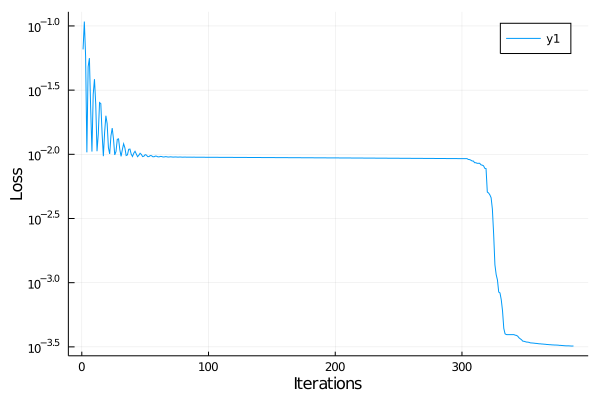

In [11]:
# Create a Basis
@variables u[1:3]
# Lots of polynomials
polys = Operation[1]

for i ∈ 1:2
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:2
        if i != j
            push!(polys, (u[1]^j)*(u[2]^i))
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

h = [polys...]

basis = Basis(h, u)

#const u_0 =  basis(C₀₂)
 
nrxn = 1
ncomp = 3
nbasis = length(basis.basis)
Lstoi = FastChain(FastDense(1,ncomp*nrxn,tanh)) # teeny network, independent of concentrations
ps = initial_params(Lstoi)
Lrxn = FastChain(FastDense(nbasis,nrxn,tanh), FastDense(nrxn,nrxn))
pr = initial_params(Lrxn)
L_dualexpand(u,p) = reshape(Lstoi(0.0,p[1:(ncomp*nrxn*2)]),ncomp,nrxn)*Lrxn(u,p[(ncomp*nrxn*2+1):end])

basisinputs = Lrxn.layers[1]
basisinputs_nparams =  DiffEqFlux.paramlength(Lrxn.layers[1])

function dudt_nn2x(u, p,t)
    A,B,C = u
    d = L_dualexpand(basis(u),p)  # make the problem easy for now
    [d[1],
    d[2],
    d[3]]
end
p = [ps;pr]
prob_nn2x = ODEProblem(dudt_nn2x,C₀₂, (0.0,maximum(tspan_SD)), p)

function predict(θ)
    solution2 = solve(prob_nn2x, Vern7(),u0 = C₀₂, p=θ, saveat = tspan_SD,
                         abstol=1e-6, reltol=1e-6,save_idxs=[1,2,3],
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP()))
    hcat(solution2.u...)
end

# No regularisation right now, perhaps try multi starting?
function loss(θ)
    pred = predict(θ)
    # norm(θ,1) #add L1 penalty for reactions

    sum(abs2, (Xₙ.- pred)), pred
end

losses = []

callback(θ,l,pred) = begin
    push!(losses, l)
    false
end

# First train with ADAM for better convergence
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.001), cb=callback, maxiters = 300,save_best=true)

# Train with BFGS
res22x = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 300)

println("Final training loss for two network model after $(length(losses)) iterations: $(losses[end])")

# Plot the losses
plot(losses, yaxis = :log, xlabel = "Iterations", ylabel = "Loss")

L2 of full solutions 0.1299700442749234


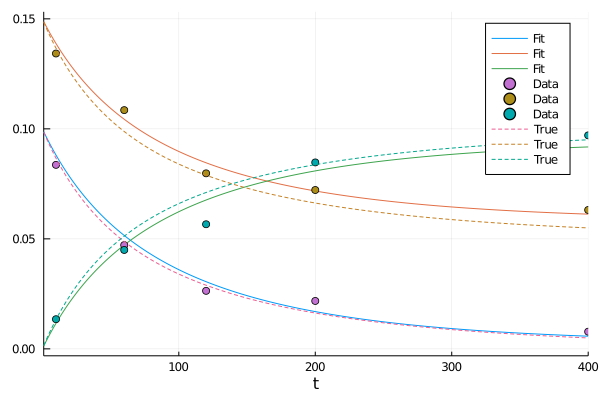

In [12]:
# Plot the data the truth, and the approximation
NNsolution = solve(prob_nn2x, saveat = tspan_HD, p=res22x.minimizer,verbose = false,save_idxs = [1,2,3], save_everystep = false)
println("L2 of full solutions $(norm(NNsolution-solution2_HD,2))")
plot(NNsolution,labels="Fit")
scatter!(solution2_SD.t,Xₙ',label="Data")  
plot!(solution2_HD,line=:dash,label="True")  

Even better, (with a smaller network!) thanks to the use of the basis functions as the NN input!

# Try SINDy with the data set
Attempt to identify the true model with SINDy, borrowing code from the other examples.  Start by redefining the basis set:

In [13]:
# Create a Basis
@variables u[1:3]
# Lots of polynomials
polys = Operation[1]

for i ∈ 1:2
    push!(polys, u[1]^i)
    push!(polys, u[2]^i)
    for j ∈ i:2
        if i != j
            push!(polys, (u[1]^j)*(u[2]^i))
            push!(polys, (u[1]^i)*(u[2]^j))
            push!(polys, u[2]^i*u[1]^i)
        end
    end
end

h = [polys...]

basis = Basis(h, u)

8 dimensional basis in ["u₁", "u₂", "u₃"]

Select some data, here the sparsely sampled data:

In [14]:
X = hcat(solution2_SD.u...)
ϵ= 0.08./2*maximum(X)
Random.seed!(123) # set seed
Xₙ = X + (ϵ)*randn(eltype(X), size(X))
;

Calculate the true derivative from the model, plus the NN approximation:

In [15]:
DX = Array(solution2_SD(solution2_SD.t, Val{1}))
L̂ = L_dualexpand(basis(Xₙ),res22x.minimizer)
;

Run SINDy for the ideal case:

In [16]:
# Create an optimizer for the SINDy problem
opt = SR3()
# Create the thresholds which should be used in the search process
λ = exp10.(-7:0.1:3)
# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 100000,normalize=true, denoise=true) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 6
Active terms : 6
   Equation 1 : 2
   Equation 2 : 2
   Equation 3 : 2
Overall error (L2-Norm) : 0.002356789048529337
   Equation 1 : 0.0007855963498618232
   Equation 2 : 0.0007855963488046671
   Equation 3 : 0.0007855963498628468
AICC :
   Equation 1 : 56.59626978896418
   Equation 2 : 56.596269794346874
   Equation 3 : 56.59626978895897

SR3{Float64,UnionAll}(1.9905358527674845e-8, 1.0, ProximalOperators.NormL1) did not converge after 100000 iterations.

3 dimensional basis in ["u₁", "u₂", "u₃"]
du₁ = p₁ + p₂ * u₂
du₂ = p₃ + p₄ * u₂
du₃ = p₅ + p₆ * u₂



SINDy fails even for the ideal case!  Does it need more data, or should the settings get tweaked?

In [17]:
# Test on uode derivative data
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 10000, normalize = true, denoise = true) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 24
Active terms : 24
   Equation 1 : 8
   Equation 2 : 8
   Equation 3 : 8
Overall error (L2-Norm) : 0.0003083970460363679
   Equation 1 : 0.00010577037697966172
   Equation 2 : 9.962059978983198e-5
   Equation 3 : 0.00010300606926687417
AICC :
   Equation 1 : 22.616960273940954
   Equation 2 : 22.856566358239952
   Equation 3 : 22.72289058619814

SR3{Float64,UnionAll}(7.924465962305556e-10, 1.0, ProximalOperators.NormL1) converged after 16 iterations.

3 dimensional basis in ["u₁", "u₂", "u₃"]
du₁ = p₁ + u₁ ^ 2 * p₇ + u₂ ^ 2 * p₈ + p₂ * u₁ + p₃ * u₂ + u₁ ^ 2 * p₄ * u₂ + u₂ ^ 2 * p₅ * u₁ + p₆ * u₁ * u₂
du₂ = p₉ + u₁ ^ 2 * p₁₅ + u₂ ^ 2 * p₁₆ + p₁₀ * u₁ + p₁₁ * u₂ + u₁ ^ 2 * p₁₂ * u₂ + u₂ ^ 2 * p₁₃ * u₁ + p₁₄ * u₁ * u₂
du₃ = p₁₇ + u₁ ^ 2 * p₂₃ + u₂ ^ 2 * p₂₄ + p₁₈ * u₁ + p₁₉ * u₂ + u₁ ^ 2 * p₂₀ * u₂ + u₂ ^ 2 * p₂₁ * u₁ + p₂₂ * u₁ * u₂



No surprise, SINDy fails here too.

# Conclusions
Because we dont have observations for all species, I'm not sure that  SINDy can work effectively for missing species even if it worked under the ideal scenarios examined.  With the ODE neural network formulation, hitting local minima is a risk.  But by restricting the structure using our knowledge of reactive systems, effective approximations of the true system can be made.  

# Appendix: Pkg.status()

In [18]:
versioninfo()

Julia Version 1.5.2
Commit 539f3ce943 (2020-09-23 23:17 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i3-4130 CPU @ 3.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, haswell)
Environment:
  JULIA_CMDSTAN_HOME = /home/jak/cmdstan-2.24.1
  JULIA_NUM_THREADS = 4


In [19]:
]status

Status `~/Dropbox/julia/universal_differential_equations/ChemicalKinetics/Project.toml`
  [6e4b80f9] BenchmarkTools v0.5.0
  [336ed68f] CSV v0.8.2
  [479239e8] Catalyst v5.1.0
  [717857b8] DSP v0.6.10
  [2445eb08] DataDrivenDiffEq v0.4.1 `https://github.com/SciML/DataDrivenDiffEq.jl#master`
  [a93c6f00] DataFrames v0.21.8
  [2b5f629d] DiffEqBase v6.48.2
  [ebbdde9d] DiffEqBayes v2.17.0
  [aae7a2af] DiffEqFlux v1.24.0
  [41bf760c] DiffEqSensitivity v6.33.0
  [0c46a032] DifferentialEquations v6.15.0
  [31c24e10] Distributions v0.23.12
  [6a86dc24] FiniteDiff v2.7.2
  [26cc04aa] FiniteDifferences v0.10.9
  [587475ba] Flux v0.11.1
  [f6369f11] ForwardDiff v0.10.14
  [7073ff75] IJulia v1.23.0
  [a98d9a8b] Interpolations v0.12.10
  [5ab0869b] KernelDensity v0.6.2
  [23992714] MAT v0.8.1
  [429524aa] Optim v1.2.0
  [1dea7af3] OrdinaryDiffEq v5.44.0
  [91a5bcdd] Plots v1.7.3
  [d330b81b] PyPlot v2.9.0
  [c6596682] QuantileRegressions v0.1.6
  [276daf66] SpecialFunctions v0.10.3
  [90137ffa] St